# Evaluating a NnPotential with htvs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../NeuralForceField/')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error

from dbsetting import *
from neuralnet.utils.nff import create_nff_dataset
from neuralnet.utils.data import remove_outliers, get_props

import nff
from nff.data import Dataset, split_train_validation_test, collate_dicts, concatenate_dict, to_tensor
from nff.train import get_model, load_model, evaluate, loss, Trainer
import nff.utils.constants as ct

In [4]:
DEVICE = 3
BATCH_SIZE = 15
MODEL_PATH = '/home/dskoda/data/models/451/'

## Loading the relevant data

### Generating a test set for NnPotential

In [5]:
nn = NnPotential.objects.get(id=451)

In [6]:
mygroup = Group.objects.get(name='zeolite')
mymethod = Method.objects.get(name='dft_d3_gga_bp86')
myconfigs = JobConfig.objects.filter(
    name__in=['bp86_d3_svp_opt_orca',
              'hessian_displacement_bp86_d3_svp_opt_orca',
              'neuralmd'
             ]
)

silicates = (Species.objects
    .filter(group=mygroup)
    .filter(smiles__contains='Si')
    .filter(smiles__contains='O')
    .exclude(smiles__contains='C')
    .exclude(smiles__contains='Al')
    .exclude(smiles__contains='B')
)

myspecies = Species.objects.filter(id__in=nn.trainingset.values_list('species__id', flat=True))

In [12]:
test_set_ids = list(Geom.objects
    .filter(species__in=myspecies)
    .filter(parentjob__config__in=myconfigs)
    .exclude(id__in=nn.trainingset.values_list('id', flat=True))
    .order_by('?')
    .values_list('id', flat=True)
)[:1000]

In [13]:
test_geoms = Geom.objects.filter(id__in=test_set_ids)

In [14]:
dataset, loader = create_nff_dataset(
    test_geoms,
    project_name='zeolite',
    method_name='dft_d3_gga_bp86',
    nbrlist_cutoff=5,
    batch_size=BATCH_SIZE,
    num_workers=2,
    std_away=4,
    max_value = 3000 / ct.HARTREE_TO_KCAL_MOL
)

In [15]:
loss_fn = loss.build_mse_loss({'energy': 0.01, 'energy_grad': 1})

model = torch.load(
    os.path.join(MODEL_PATH, 'best_model'),
    map_location=lambda storage, loc: storage
)

/home/dskoda/packages/conda/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'nff.nn.models.SchNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/dskoda/packages/conda/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/dskoda/packages/conda/envs/htvs/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve t

## Evaluation

In [16]:
def plot_hexbin(pred, targ, ax, key, scale='log', plot_helper_lines=False, lims=None): 
    
    units = {
        'energy_grad': r'kcal/mol/$\AA$',
        'energy': 'kcal/mol'
    }

    mae = mean_absolute_error(targ, pred)
    
    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8
    
    if lims is None:
        lim_min = min(np.min(pred), np.min(targ)) * 1.1
        lim_max = max(np.max(pred), np.max(targ)) * 1.1
    else:
        lim_min, lim_max = lims
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    hb = ax.hexbin(
        pred, targ,
        cmap='viridis',
        gridsize=60,
        bins='log',
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
        extent=(lim_min, lim_max, lim_min, lim_max)
    )
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    if plot_helper_lines:
        
        if scale == 'linear':
            x = np.linspace(lim_min, lim_max, 50)
            y_up = x + mae
            y_down = x - mae         
            
        elif scale == 'log':
            x = np.logspace(np.log10(lim_min), np.log10(lim_max), 50)
            
            # one order of magnitude
            y_up = np.maximum(x + 1e-2, x * 10)
            y_down = np.minimum(np.maximum(1e-8, x - 1e-2), x / 10)
            
            # one kcal/mol/Angs
            y_up = x + 1
            y_down = np.maximum(1e-8, x - 1)
            
        
        for y in [y_up, y_down]:
            ax.plot(x,
                    y,
                    color='#000000',
                    zorder=2,
                    linewidth=0.5,
                    linestyle='--')
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
    
    ax.annotate('MAE: %.3f %s' % (mae, units[key]),
                (0.03, 0.95),
                xycoords='axes fraction',
                fontsize=12)
    
    return ax, hb

In [17]:
def plot_error(pred, targ, ax, key, scale='linear', bins=None): 
    
    units = {
        'energy_grad': r'kcal/mol/$\AA$',
        'energy': 'kcal/mol'
    }

    error = np.abs(targ - pred)
    mae = np.average(error)
    
    if bins is None:
        bins = 20 if scale == 'linear' else np.logspace(-7, 2, 10 * 2)
    
    hist = ax.hist(
        error,
        bins=bins,
        color='#1f77b4',
        log=(scale == 'log'),
    )
    
    if scale == 'log':
        ax.set_xscale(scale)
            
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('absolute error (%s)' % (units[key]), fontsize=12)
    ax.set_ylabel('counts', fontsize=12)
    
    ax.annotate('MAE: %.3f %s' % (mae, units[key]),
                (0.03, 0.95),
                xycoords='axes fraction',
                fontsize=12)
    
    return ax, hist


def plot_error_map(pred, targ, ax, key, scale='linear', bins=None, normalize=False): 
    
    units = {
        'energy_grad': r'kcal/mol/Å',
        'energy': 'kcal/mol'
    }

    error = np.abs(targ - pred) + 1e-10
    mae = np.average(error)
       
    if scale == 'log':
        targ = np.abs(targ) + 1e-10
    
    if normalize:
        error = error / targ * 100
    
    hist = ax.hexbin(
        targ, error,
        cmap='viridis',
        gridsize=40,
        bins='log',
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
    )
            
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('target %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel(
        '%s error (%s)' % (('relative', r'%') if normalize else ('absolute', units[key])),
        fontsize=12
    )
    
    ax.annotate('MAE: %.3f %s' % (mae, units[key]),
                (0.03, 0.95),
                xycoords='axes fraction',
                fontsize=12)
    
    return ax, hist

### Validation set

In [18]:
results, targets, val_loss = evaluate(model, loader, loss_fn, DEVICE)

/home/dskoda/packages/conda/envs/htvs/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


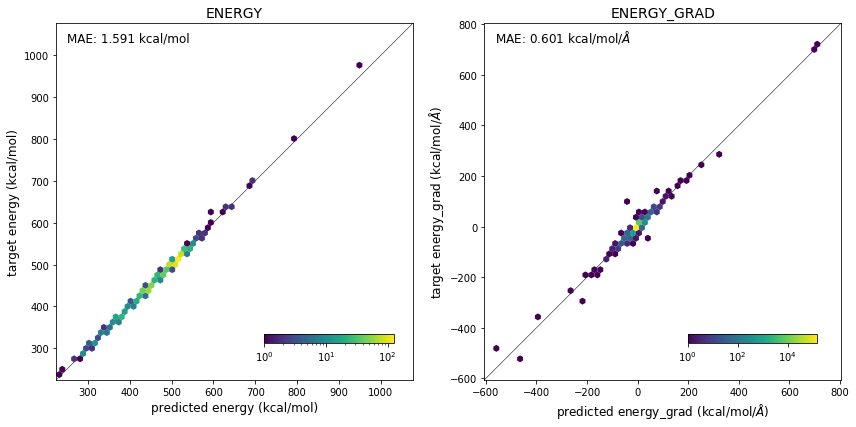

In [19]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

keys = ['energy', 'energy_grad']
hexbins = []
for ax, key in zip(ax_fig, keys):
    pred = torch.cat(results[key], dim=0).reshape(-1).numpy()
    targ = torch.cat(targets[key], dim=0).reshape(-1).numpy()
    
    scale = 'linear'

#     lims = (-3000, 3000) if (key == 'energy_grad') else None
    lims = None
    
    ax, hb = plot_hexbin(pred, targ, ax, key, scale, lims=lims)
    hexbins.append(hb)

for left, hb in zip([0.31, 0.80], hexbins):
#     left, bottom, width, height = ax.get_position().bounds
    cax = fig.add_axes([left, 0.2, 0.15, 0.02])
    cbar = fig.colorbar(hb, shrink=.65, cax=cax, orientation='horizontal')
#     cbar.set_label('counts', fontsize=12)

plt.tight_layout()
plt.show()

#### Error distributions

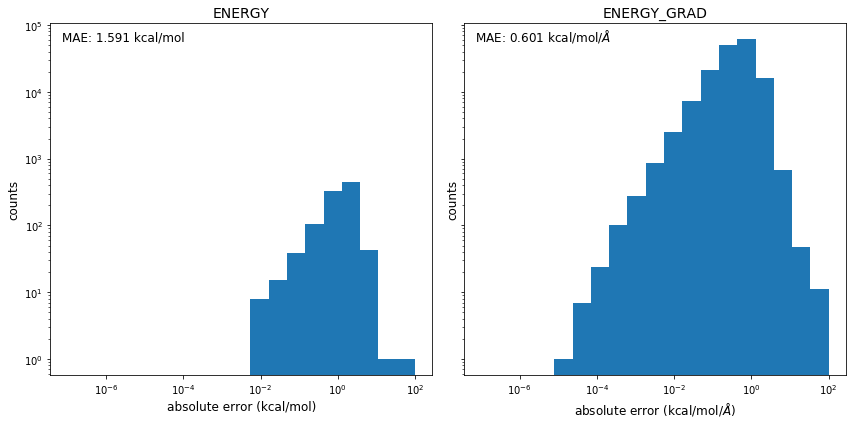

In [20]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

hexbins = []
for ax, key in zip(ax_fig, ['energy', 'energy_grad']):
    pred = torch.cat(results[key], dim=0).reshape(-1).numpy()
    targ = torch.cat(targets[key], dim=0).reshape(-1).numpy()
    
    scale = 'log'    
    ax, hist = plot_error(pred, targ, ax, key, scale)

plt.tight_layout()
plt.show()

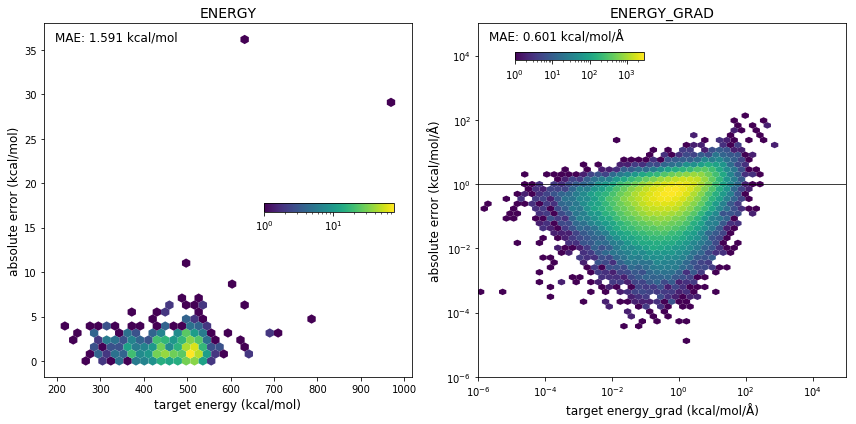

In [21]:
fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

hexbins = []
for ax, key in zip(ax_fig, ['energy', 'energy_grad']):
    pred = torch.cat(results[key], dim=0).reshape(-1).numpy()
    targ = torch.cat(targets[key], dim=0).reshape(-1).numpy()
    
    scale = 'log' if key == 'energy_grad' else 'linear'
    ax, hb = plot_error_map(pred, targ, ax, key, scale, normalize=False)
    hexbins.append(hb)

for left, bottom, hb in zip([0.31, 0.60], [0.5, 0.85], hexbins):
#     left, bottom, width, height = ax.get_position().bounds
    cax = fig.add_axes([left, bottom, 0.15, 0.02])
    cbar = fig.colorbar(hb, shrink=.65, cax=cax, orientation='horizontal')
#     cbar.set_label('counts', fontsize=12)

ax_fig[1].set_xlim(1e-6, 1e5)
ax_fig[1].set_ylim(1e-6, 1e5)

ax_fig[1].plot([1e-6, 1e5], [1, 1], color='k', linewidth=0.75)
plt.tight_layout()
plt.show()